# CS598 Deep Learning for Healthcare Reproducibility Project
Esther Tang
(esthert2@illinois.edu)

The paper I attempted to reproduce was [_Imputation Strategies Under Clinical Presence: Impact on Algorithmic Fairness_](https://proceedings.mlr.press/v193/jeanselme22a/jeanselme22a.pdf) by Jeanselme et al. (2022)$^{[1]}$. This paper studies the impact of using imputation to fill in missing data.

Because the data used in deep learning for healthcare comes from patients interacting with the healthcare system, inequitable patterns in these interactions translate to inequitable patterns in healthcare data. If we train machine learning models on this data, we could be further cementing some of these patterns of inequities in our healthcare systems.

The authors suggest 3 possible causes of data missingness: 
1. Limited access to healthcare, often due to structural inequalities.
2. Mis-informed data collection, where patients in certain groups may not display “textbook” symptoms and, therefore, may not be tested for a disease.
3. Confirmation bias is involved, as practitioners have been shown to only collect data or order labs when they think a patient is ill.

Researchers will often fill in missing data using imputation, but the impacts of this are understudied and overlooked. This paper attempts to help analyze the effects that different imputation strategies have on marginalized populations.

### Prepare the data
The authors use both synthetic & MIMIC-III$^{[2]}$ data, but I focused on the MIMIC-III dataset in my project. 

Lab, patient, and admissions data from the MIMIC-III dataset are used to verify the paper’s results. The data is harmonized using MIMIC-Extract$^{[3]}$, and only adult patients surviving at least 24 hours are selected. This leaves us with a dataset consisting of 36,295 patients and 67 potential lab test results for each patient. 

First, place the ADMISSIONS.csv, LABEVENTS.csv, and PATIENTS.csv files from the MIMIC-III dataset in the MimicData folder. Add the itemid_to_variable_map.csv file from MIMIC_Extract to the MimicData folder.

Then, run the code below to preprocess the data.

In [5]:
# Import libraries
import io
from contextlib import redirect_stdout
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.metrics import roc_auc_score

from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import colors as plt_colors
import seaborn as sns

In [3]:
# Run the preprocessing script
with redirect_stdout(io.StringIO()):
    !python Preprocessing.py

In [75]:
# Get preprocessed data
PREPROCESSED_DATA_PATH = './PreprocessedData/'
labs = pd.read_csv(PREPROCESSED_DATA_PATH + 'preprocessed_labs.csv', index_col = [0, 1], header = [0, 1])
outcomes = pd.read_csv(PREPROCESSED_DATA_PATH + 'preprocessed_labeled_outcomes.csv', index_col = 0)

demographics = {
    'GENDER': {'data': outcomes['GENDER'], 'populations': ['Female', 'Male']}, 
    'ETHNICITY': {'data': outcomes['ETHNICITY'], 'populations': ['Black', 'Non Black']}, 
    'INSURANCE': {'data': outcomes['INSURANCE'], 'populations': ['Public', 'Private']}, 
    'Outcome': {'data': outcomes['Outcome'], 'populations': ['Death', 'Alive']}
}

# Number of patients and average lab events and tests for each demographic
lab_event_count = labs.groupby('SUBJECT_ID').size()
lab_stats = {}
# Display dataset statistics
pd.set_option('display.precision', 1)
for index, (d_name, d_values) in enumerate(demographics.items()):
  minority_subj_ids = outcomes[outcomes[d_name] == d_values['populations'][0]].index
  minority_num_events = lab_event_count[minority_subj_ids].mean()
  minority_num_labs = labs.loc[minority_subj_ids].notna().sum().sum()
  
  majority_subj_ids = outcomes[outcomes[d_name] == d_values['populations'][1]].index
  majority_num_events = lab_event_count[majority_subj_ids].mean()
  majority_num_labs = labs.loc[majority_subj_ids].notna().sum().sum()

  lab_stats[d_name] = {
      d_values['populations'][1]: {
          '# of Patients': len(majority_subj_ids), 
          'Avg # Lab Events': majority_num_events, 
          'Avg # Lab Tests': majority_num_labs / len(majority_subj_ids)},
      d_values['populations'][0]: {
          '# of Patients': len(minority_subj_ids), 
          'Avg # Lab Events': minority_num_events, 
          'Avg # Lab Tests': minority_num_labs / len(minority_subj_ids)}
  }

lab_stats_df = pd.DataFrame.from_dict({(i,j): lab_stats[i][j] 
                                       for i in lab_stats.keys() 
                                       for j in lab_stats[i].keys()},
                                      orient='index')
display(lab_stats_df)

# of Patients  Avg # Lab Events  Avg # Lab Tests
GENDER    Male               20592               6.1             56.0
          Female             15703               5.5             52.3
ETHNICITY Non Black          33515               5.9             54.8
          Black               2780               5.1             49.5
INSURANCE Private            12136               6.2             57.0
          Public             24159               5.7             53.1
Outcome   Alive              33858               5.7             53.5
          Death               2437               7.3             66.7

### Run the experiment
Four data imputation strategies are applied to the processed data: 
1. Simple Median Imputation
2. MICE 
3. Group MICE
4. Group MICE Missing 

The paper examines how these four imputation methods impact the performance of a logistic regression model as it predicts short-term survival for the entire population and for marginalized groups.

Run the following code to 1) apply the four imputation methods and 2) use the logistic regression to generate predictions for the survival of each patient in the processed dataset. (Note: This may take 3+ hours to complete.)

In [110]:
# Run the experiment script
with redirect_stdout(io.StringIO()):
    !python Experiment.py

### Analyze the results
Using the predictions generated by the Experiment.py script, we can now examine the impact of each imputation method on the logistic regression's ability to predict outcomes for the overall population as well as for each demographic group.

Run the code below to obtain the experiment results and to generate the AUC ROC, Prioritization Percentage, and False Negative Rate (FNR).

In [76]:
# Get experiment results
EXPERIMENT_RESULTS_PATH = './ExperimentResults/'
predictions = {}
for imputation in ['Median', 'MICE', 'Group MICE', 'Group MICE Missing']:
  predictions[imputation] = pd.read_csv(EXPERIMENT_RESULTS_PATH + 'experiment_results_' + imputation + '.csv', index_col = 0)

In [77]:
def calculateMetrics(y_pred, y_true, demo_data, demo_populations, threshold_percent = 0.3, iterations = 100):
  # Threshold for % of patients to prioritize (default is top 30%)
  threshold_top = pd.Series(y_pred).nlargest(int(len(y_pred) * threshold_percent), keep = 'all').min()

  # Prepare to collect calculated metrics
  metric_list = ['AUC ROC', 'Prioritized Percentage', 'Wrongly not prioritized (FNR)']
  bootstrap_values = {}
  average_metrics = {}
  gap_metrics = {}

  for pop_index, population in enumerate(demo_populations):
    # Placeholders for storing results
    bootstrap_values[population] = {}
    average_metrics[population] = {}
    for metric in metric_list:
      bootstrap_values[population][metric] = []
    
    # Get y_pred and y_true data for this population
    if population == 'Overall':
      y_pred_pop = y_pred
      y_true_pop = y_true
    else:
      y_pred_pop = y_pred[demo_data == population]
      y_true_pop = y_true[demo_data == population]

    # Use bootstrap method for validation
    for i in range(iterations):
      # Select bootstrap sample
      bootstrap = np.random.choice(np.arange(len(y_pred_pop)), size = len(y_pred_pop), replace = True)
      this_y_pred = y_pred_pop[bootstrap]
      this_y_true = y_true_pop[bootstrap]

      # Get metrics for boostrapped sample
      bootstrap_values[population]['AUC ROC'].append(roc_auc_score(this_y_true, this_y_pred))
      selected = this_y_pred >= threshold_top
      bootstrap_values[population]['Prioritized Percentage'].append(np.mean(selected)) # Percentage of patients in this demo group that are prioritized
      bootstrap_values[population]['Wrongly not prioritized (FNR)'].append((this_y_true[~selected]).sum() / this_y_true.sum()) # Wrongly not prioritized

    # Aggregate metrics using averages
    for metric in metric_list:
      # Average metrics
      average_metrics[population][metric] = np.mean(bootstrap_values[population][metric])
      # Population gap metrics
      if pop_index == 1:
        gap_metrics[metric] = average_metrics[demo_populations[0]][metric] - average_metrics[demo_populations[1]][metric]

  return average_metrics, gap_metrics

In [78]:
# Calculate metrics for each population and imputation strategy
average_metrics = {}
gap_metrics = {}
for demo_key, demo_val in demographics.items():
  # Overall stats only need to be calculated once
  if demo_key == 'Outcome':
    demo_key = 'OVERALL'
    demo_val = {'data': outcomes, 'populations': ['Overall']}
  average_metrics[demo_key] = {}
  gap_metrics[demo_key] = {}
  for imputation in predictions:
    np.random.seed(42)
    imputation_predictions = predictions[imputation]
    test_indices = imputation_predictions[imputation_predictions['Train Test Label'].str.contains('Test')].index
    y_pred_test = imputation_predictions.loc[test_indices]['Mean'].values
    y_true_test = outcomes['Outcome'].loc[test_indices].values == 'Death'
    average_metrics[demo_key][imputation], gap_metrics[demo_key][imputation] = calculateMetrics(y_pred_test, y_true_test, demo_val['data'].loc[test_indices], demo_val['populations'])

# Format average metric results into clean dataframe
average_metrics_df = pd.DataFrame([[demographic, strategy, population, metric, value]
                               for demographic, d in average_metrics.items()
                               for strategy, s in d.items()
                               for population, p in s.items()
                               for metric, value in p.items()],
                              columns = ['Demographic', 'Strategy', 'Population', 'Metric', 'Value'])

# Format gap metric results into clean dataframe
gap_metrics_df = pd.DataFrame([[demographic, strategy, metric, value]
                               for demographic, d in gap_metrics.items()
                               for strategy, s in d.items()
                               for metric, value in s.items()],
                              columns = ['Demographic', 'Strategy', 'Metric', 'Value'])

In [79]:
# Set table and chart defaults
# Set precision
pd.set_option('display.precision', 3)
# Set dots per inches
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
sns.set_theme(style = "darkgrid", font_scale = 1, rc = {'figure.dpi':300, 'savefig.dpi':300})

#### Overall Results
These are all the results obtained from running the reproducibility experiment. Results can be compared against the original paper's results.

The exact results generated by my code differed slightly from those in the original paper. This is due to randomness introduced by the linear regression model in the MICE-related strategies, as well as to a few errors in the original paper's code, including: 
- Incorrect Age calculation 
- Inconsistent labeling of minority groups
- Ethnicity data used to generate gender label

The table and graphs below represent the raw AUC ROC, Prioritized Percentage, and Wrongly Not Prioritized (FNR) values for each demographic group.

------- AUC ROC (Average) -------


Strategy                Median   MICE  Group MICE  Group MICE Missing
Demographic Population                                               
ETHNICITY   Black        0.818  0.791       0.791               0.806
            Non Black    0.741  0.733       0.736               0.785
GENDER      Female       0.735  0.729       0.732               0.772
            Male         0.755  0.742       0.742               0.798
INSURANCE   Public       0.741  0.730       0.735               0.777
            Private      0.726  0.728       0.719               0.784
OVERALL     Overall      0.746  0.738       0.740               0.787

------- Prioritized Percentage (Average) -------


/tmp/ipykernel_8917/4009527981.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes = plt.subplot(1, 3, index + 1)


Strategy                Median   MICE  Group MICE  Group MICE Missing
Demographic Population                                               
ETHNICITY   Black        0.353  0.330       0.202               0.225
            Non Black    0.295  0.297       0.308               0.306
GENDER      Female       0.324  0.327       0.364               0.356
            Male         0.281  0.279       0.250               0.256
INSURANCE   Public       0.351  0.346       0.390               0.371
            Private      0.196  0.208       0.119               0.157
OVERALL     Overall      0.300  0.300       0.300               0.299

------- Wrongly not prioritized (FNR) (Average) -------


Strategy                Median   MICE  Group MICE  Group MICE Missing
Demographic Population                                               
ETHNICITY   Black        0.192  0.264       0.375               0.439
            Non Black    0.366  0.377       0.363               0.295
GENDER      Female       0.370  0.373       0.331               0.271
            Male         0.335  0.364       0.396               0.334
INSURANCE   Public       0.320  0.335       0.301               0.248
            Private      0.486  0.492       0.598               0.512
OVERALL     Overall      0.353  0.367       0.366               0.303

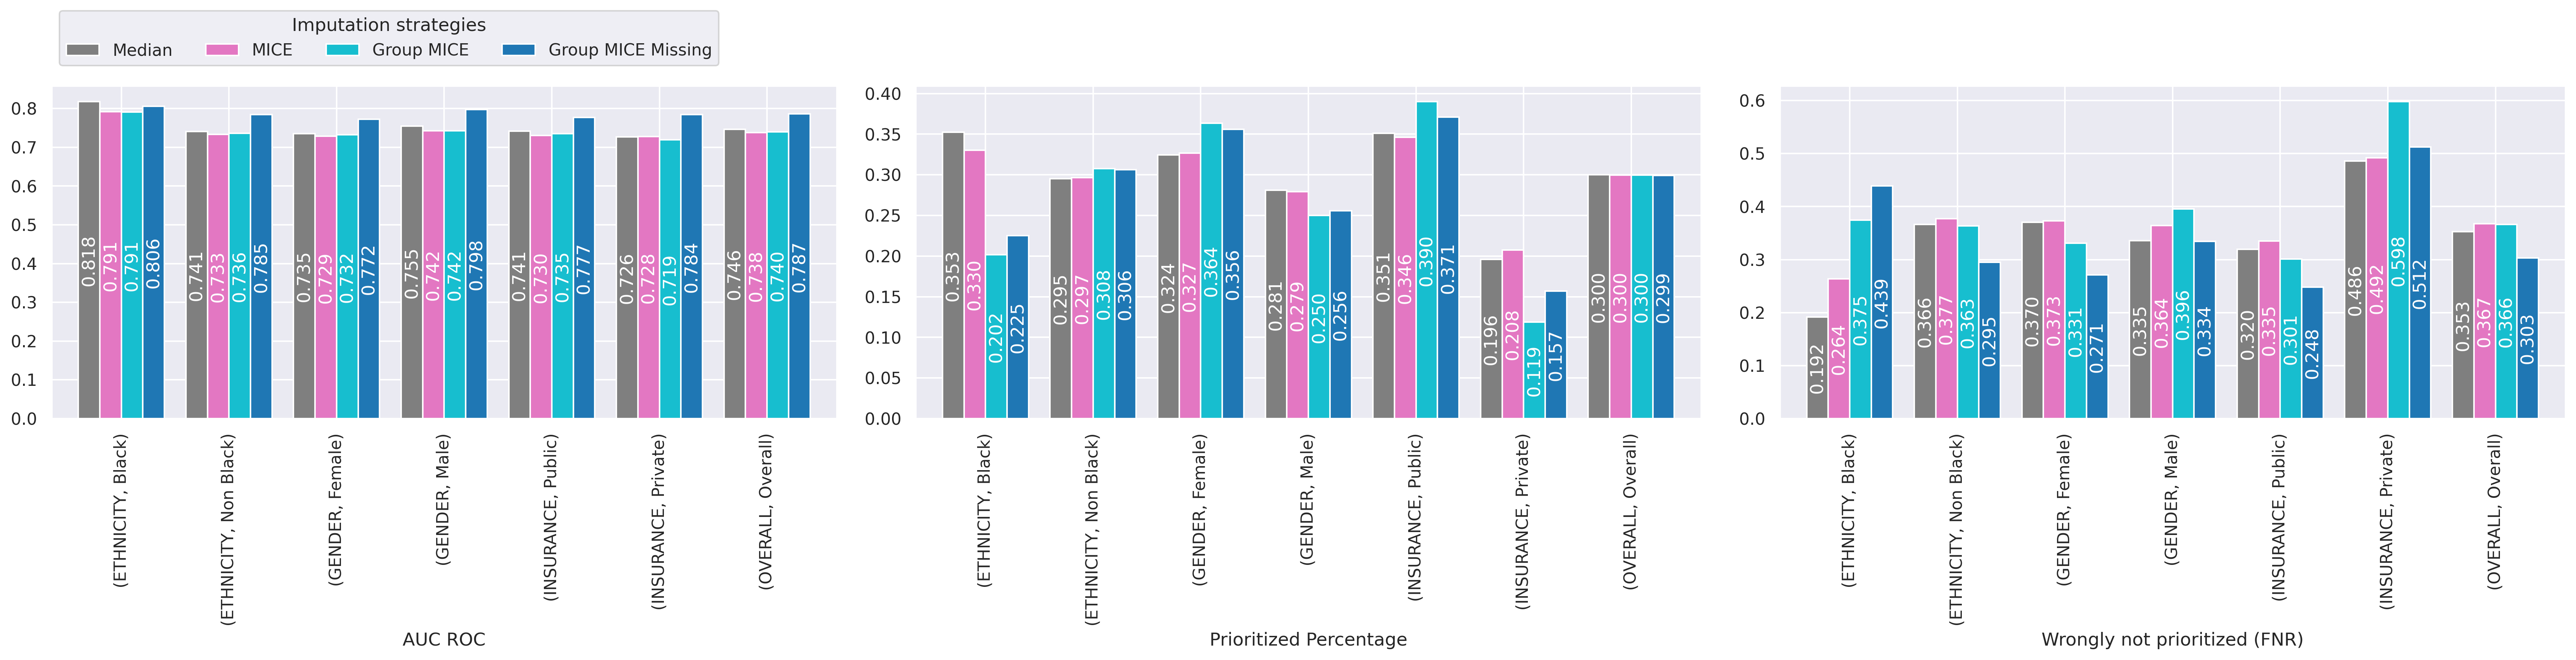

In [86]:
# Display results for each metric
plt.subplots(figsize=(30, 4))
plt.subplots_adjust(wspace = 0.1)

metric_list = ['AUC ROC', 'Prioritized Percentage', 'Wrongly not prioritized (FNR)']
for index, metric in enumerate(metric_list):
  # Display tables for each metric
  this_avg_metric = average_metrics_df[['Demographic', 'Population', 'Strategy', 'Value']][average_metrics_df['Metric'] == metric].pivot(index = ['Demographic', 'Population'], columns = 'Strategy')
  this_avg_metric.columns = this_avg_metric.columns.droplevel(0)
  this_avg_metric = this_avg_metric[['Median', 'MICE', 'Group MICE', 'Group MICE Missing']].reindex(['Black', 'Non Black', 'Female', 'Male', 'Public', 'Private', 'Overall'], level = 1)
  print('-------', metric, '(Average)', '-------')
  display(this_avg_metric)

  # Display bar graph for each metric
  axes = plt.subplot(1, 3, index + 1)
  this_avg_metric.plot.bar(ax = axes, width = 0.8, color = ['tab:gray', 'tab:pink', 'tab:cyan', 'tab:blue'])
  # Format & hide legend
  patches = [axes.patches[i * len(this_avg_metric)] for i in range(len(this_avg_metric.columns))]
  labels = this_avg_metric.columns.tolist()
  axes.legend(patches, labels, ncol = 4, loc='upper left', bbox_to_anchor=(0.0, 1.25), title = 'Imputation strategies')
  if index != 0:
    axes.get_legend().remove()
  # Format plot
  plt.ylabel('')
  plt.xlabel(metric)
  for c in axes.containers:
    plt.bar_label(c, fmt = '%.3f', rotation = 'vertical', label_type = 'center', color = 'white')

The table and graphs below represent the difference in AUC ROC, Prioritized Percentage, and Wrongly Not Prioritized (FNR) values for each minority versus majority group. For each strategy, we can see the difference in performance for: 
- Ethnicity (minority = Black, majority = Non Black)
- Gender (minority = Female, majority = Male)
- Insurance (minority = Public, majority = Private)

------- AUC ROC (Minority vs Majority Gap) -------


Strategy,Median,MICE,Group MICE,Group MICE Missing
Demographic,,,,
ETHNICITY,0.077,0.058,0.055,0.021
GENDER,-0.020,-0.014,-0.010,-0.025
INSURANCE,0.015,0.003,0.016,-0.007


------- Prioritized Percentage (Minority vs Majority Gap) -------


/tmp/ipykernel_8917/3383588820.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes = plt.subplot(1, 3, index + 1)


Strategy,Median,MICE,Group MICE,Group MICE Missing
Demographic,,,,
ETHNICITY,0.057,0.033,-0.106,-0.081
GENDER,0.043,0.047,0.114,0.100
INSURANCE,0.155,0.138,0.271,0.214


------- Wrongly not prioritized (FNR) (Minority vs Majority Gap) -------


Strategy,Median,MICE,Group MICE,Group MICE Missing
Demographic,,,,
ETHNICITY,-0.174,-0.113,0.011,0.144
GENDER,0.035,0.008,-0.064,-0.063
INSURANCE,-0.166,-0.157,-0.297,-0.264


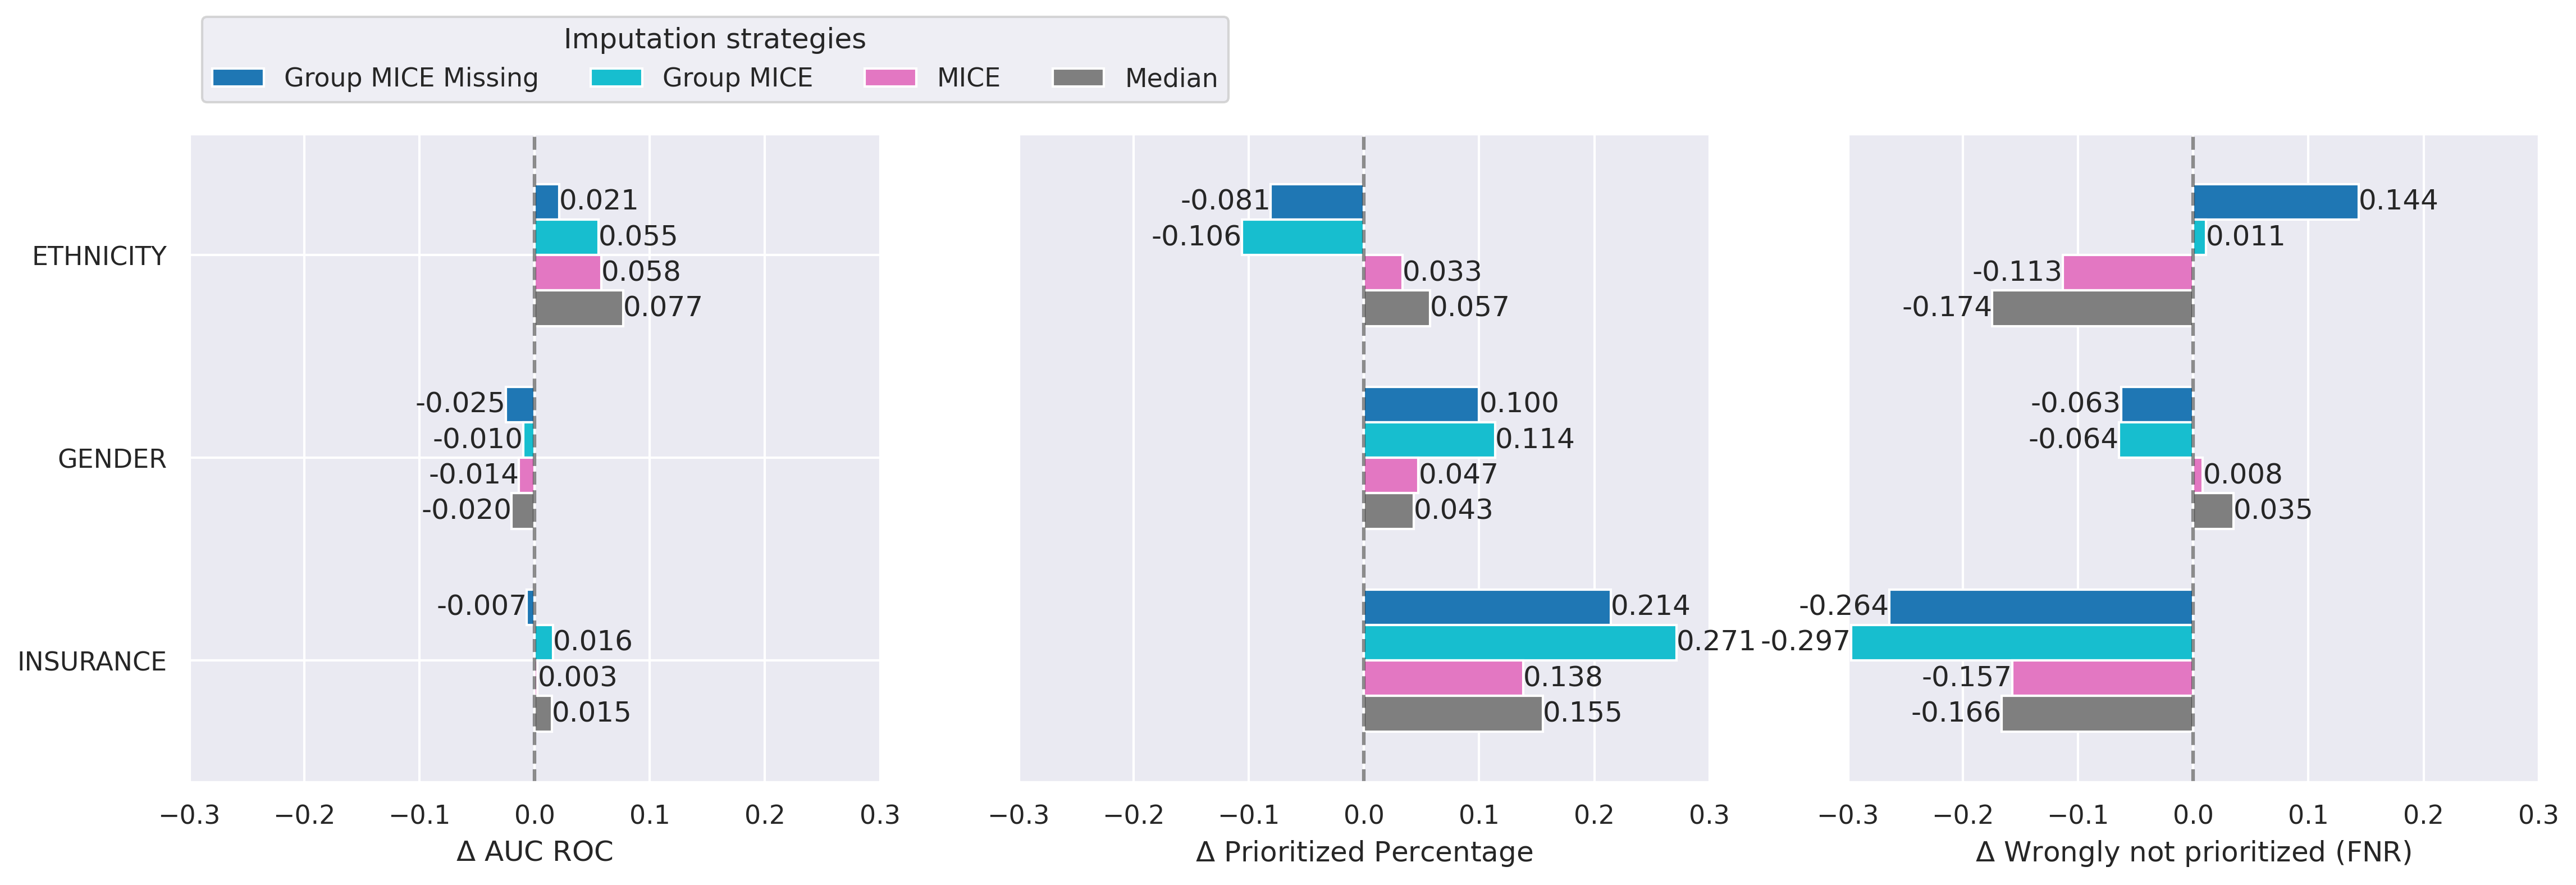

In [87]:
# Display results for each gap metric
plt.subplots(figsize=(18, 5))
for index, metric in enumerate(metric_list):
  # Display tables for each metric
  this_gap_metric = gap_metrics_df[['Demographic', 'Strategy', 'Value']][gap_metrics_df['Metric'] == metric].pivot(index = 'Demographic', columns = 'Strategy')
  this_gap_metric.columns = this_gap_metric.columns.droplevel(0)
  this_gap_metric = this_gap_metric[['Group MICE Missing', 'Group MICE', 'MICE', 'Median']]
  print('-------', metric, '(Minority vs Majority Gap)', '-------')
  display(this_gap_metric[this_gap_metric.columns[::-1]])

  # Display bar graph for each metric
  axes = plt.subplot(1, 3, index + 1)
  this_gap_metric.plot.barh(ax = axes, width = 0.7, color = ['tab:blue', 'tab:cyan', 'tab:pink', 'tab:gray'])
  # Format & hide legend
  patches = [axes.patches[i * len(this_gap_metric)] for i in range(len(this_gap_metric.columns))]
  labels = this_gap_metric.columns.tolist()
  axes.legend(patches, labels, ncol = 4, loc='upper left', bbox_to_anchor=(0.0, 1.2), title = 'Imputation strategies')
  if index != 0:
    axes.get_legend().remove()
  # Format plot
  plt.ylabel('')
  if index != 0:
    plt.yticks([])
  plt.xlim(-0.30, 0.30)
  plt.axvline(0, ls = '--', alpha = 0.5, c = 'k')
  plt.xlabel('$\Delta$ {}'.format(metric))
  for c in axes.containers:
    plt.bar_label(c, fmt = '%.3f')
  plt.gca().invert_yaxis()

#### Verification of Key Claims
Despite some differences in my results compared to the original paper's results, my results still supported the key results from the original paper. 

There are 4 main claims from the paper that I attempted to replicate:
1. Non-random missingness patterns exist in real data.
2. Imputation methods that perform equally at the population level may perform differently for specific groups.
3. There is no one “best” imputation strategy for all populations and all missingness scenarios.
4. Adding covariates or missingness indicators does not always improve performance.

Run the following code to view the results for each claim.

#### Claim 1: Non-random missingness patterns exist in real data.
We see that more lab tests are ordered for patients who end up dying, which provides evidence for a non-random missingness pattern where medical practitioners are more likely to order labs for patients they believe are ill.

We also see that minority groups receive fewer lab tests.

In [80]:
# Average # of lab events by population
# Data for line plot
bins = np.linspace(0, 24, endpoint = True)
evolution = labs.groupby('SUBJECT_ID').apply(lambda x: pd.DataFrame({
    'Cumulative number of Lab Events': np.histogram(24 * x.index.get_level_values('LOS_LAB_EVENT'), bins)[0].cumsum(), 
    'Hour after admission': bins[1:]}))

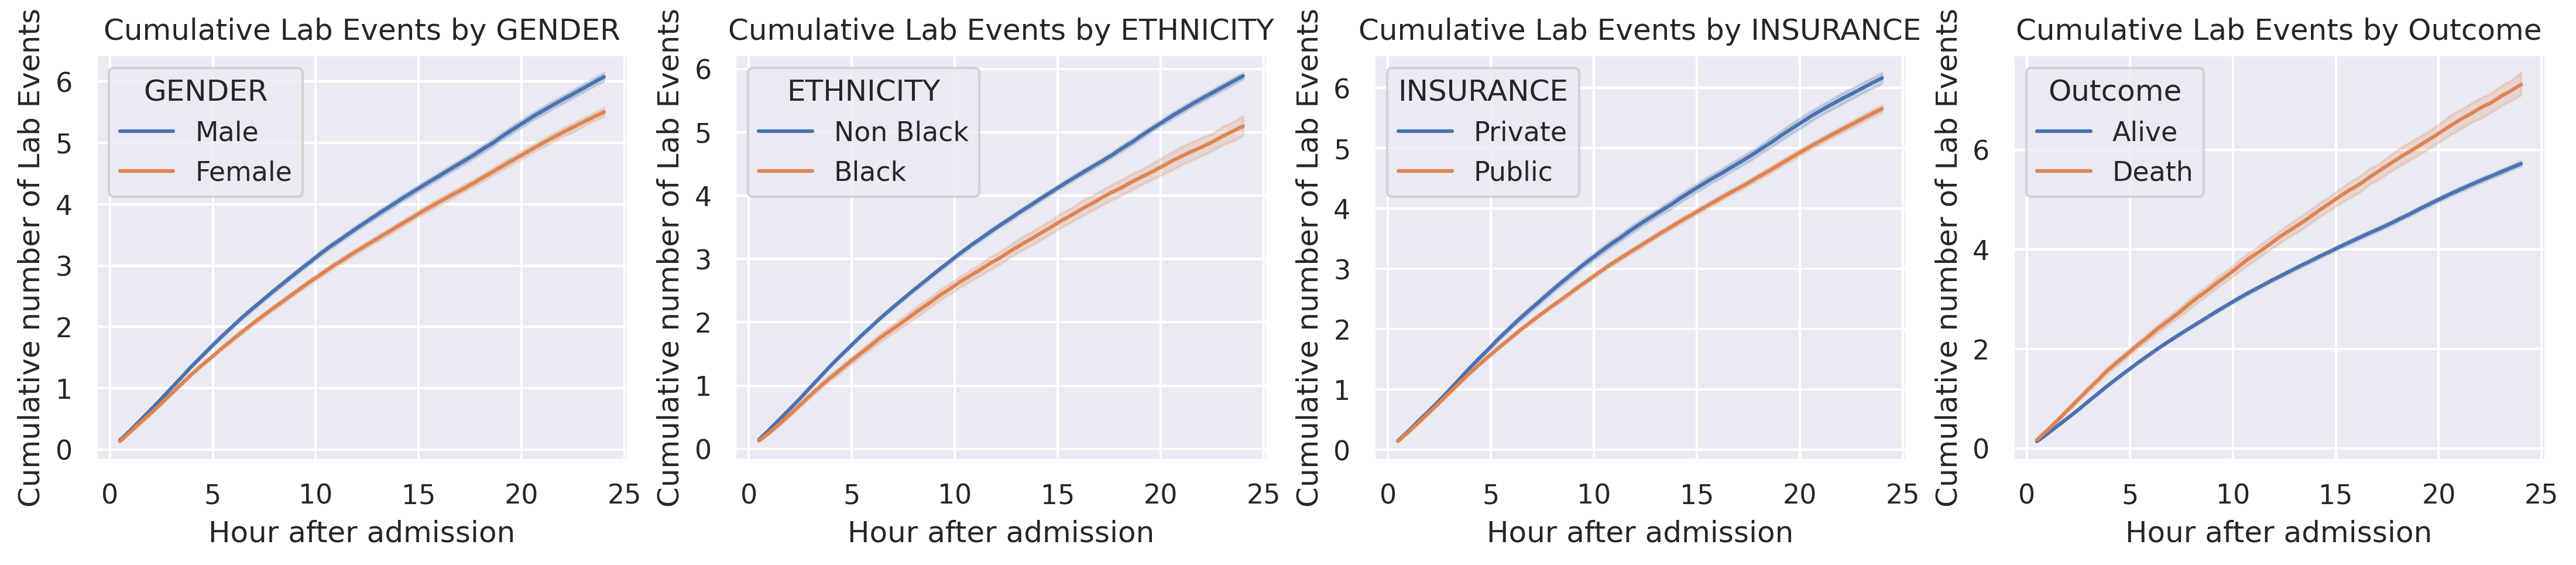

In [81]:
# Display lab events over time for each demographic
fig, axes = plt.subplots(1, 4, figsize = (18, 3))
for index, (d_name, d_values) in enumerate(demographics.items()):
  sns.lineplot(ax = axes[index], data = evolution.join(d_values['data']),
               x = "Hour after admission", y = "Cumulative number of Lab Events", 
               hue = d_name, hue_order = d_values['populations'][::-1]).set(title = 'Cumulative Lab Events by ' + d_name)

/tmp/ipykernel_8917/1480015801.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes = plt.subplot(1, 4, index + 1)


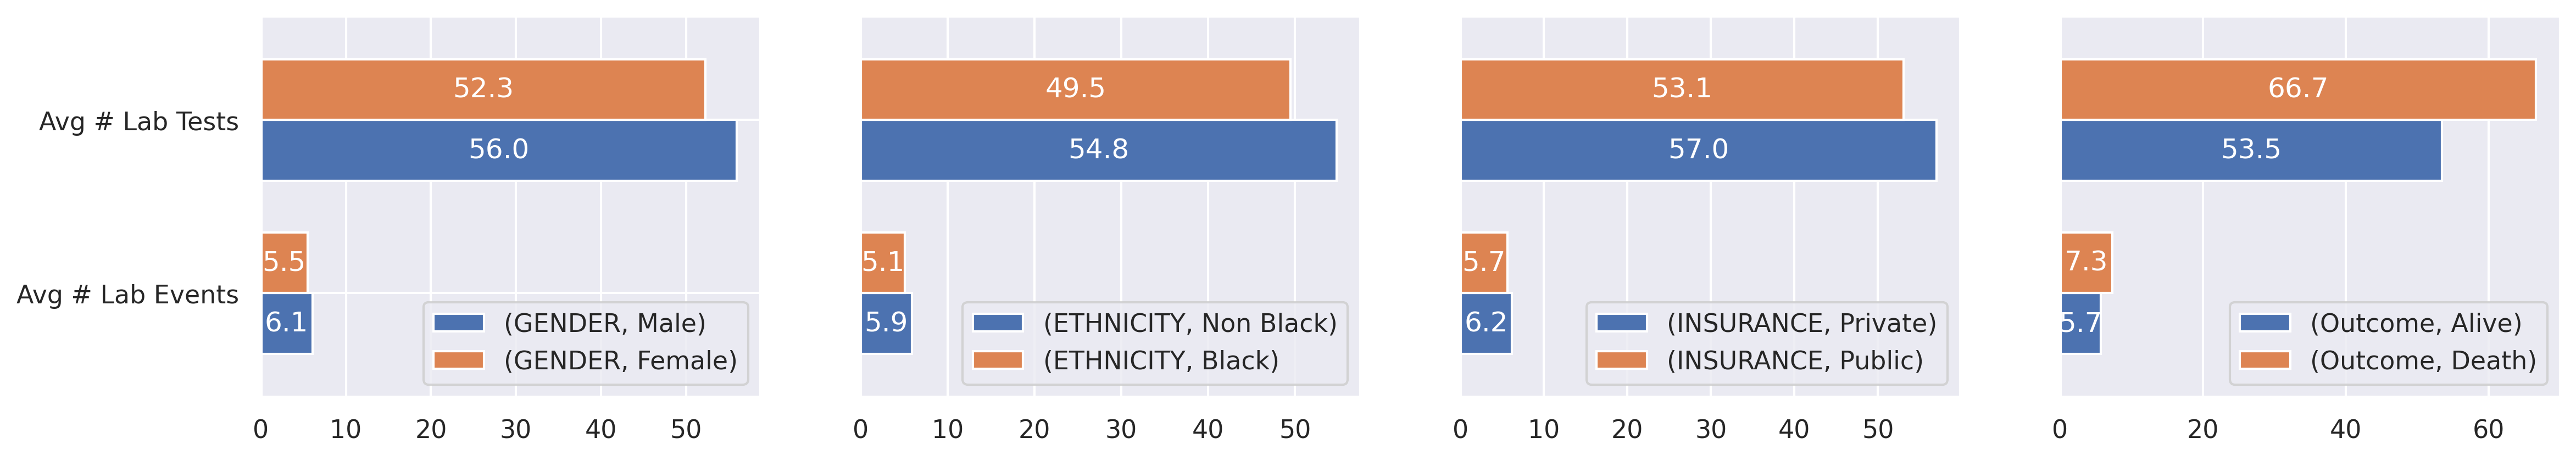

In [82]:
# Display average lab events and tests for each demographic
plt.subplots(figsize=(18, 3))
for index, (d_name, d_values) in enumerate(demographics.items()):
  axes = plt.subplot(1, 4, index + 1)
  lab_stats_df.T[[(d_name, d_values['populations'][1]), (d_name, d_values['populations'][0])]].loc[['Avg # Lab Events', 'Avg # Lab Tests']].plot.barh(ax = axes, width = 0.7)
  axes.legend(title = '')
  if index != 0:
    plt.yticks([])
  for c in axes.containers:
    plt.bar_label(c, fmt='%.1f', label_type = 'center', color = 'white')

#### Claim 2: Imputation methods that perform equally at the population level may perform differently for specific groups.
For example, MICE and Group MICE have similar overall AUC scores at the population level. However, MICE improves performance for Black patients, while Group MICE worsens it.

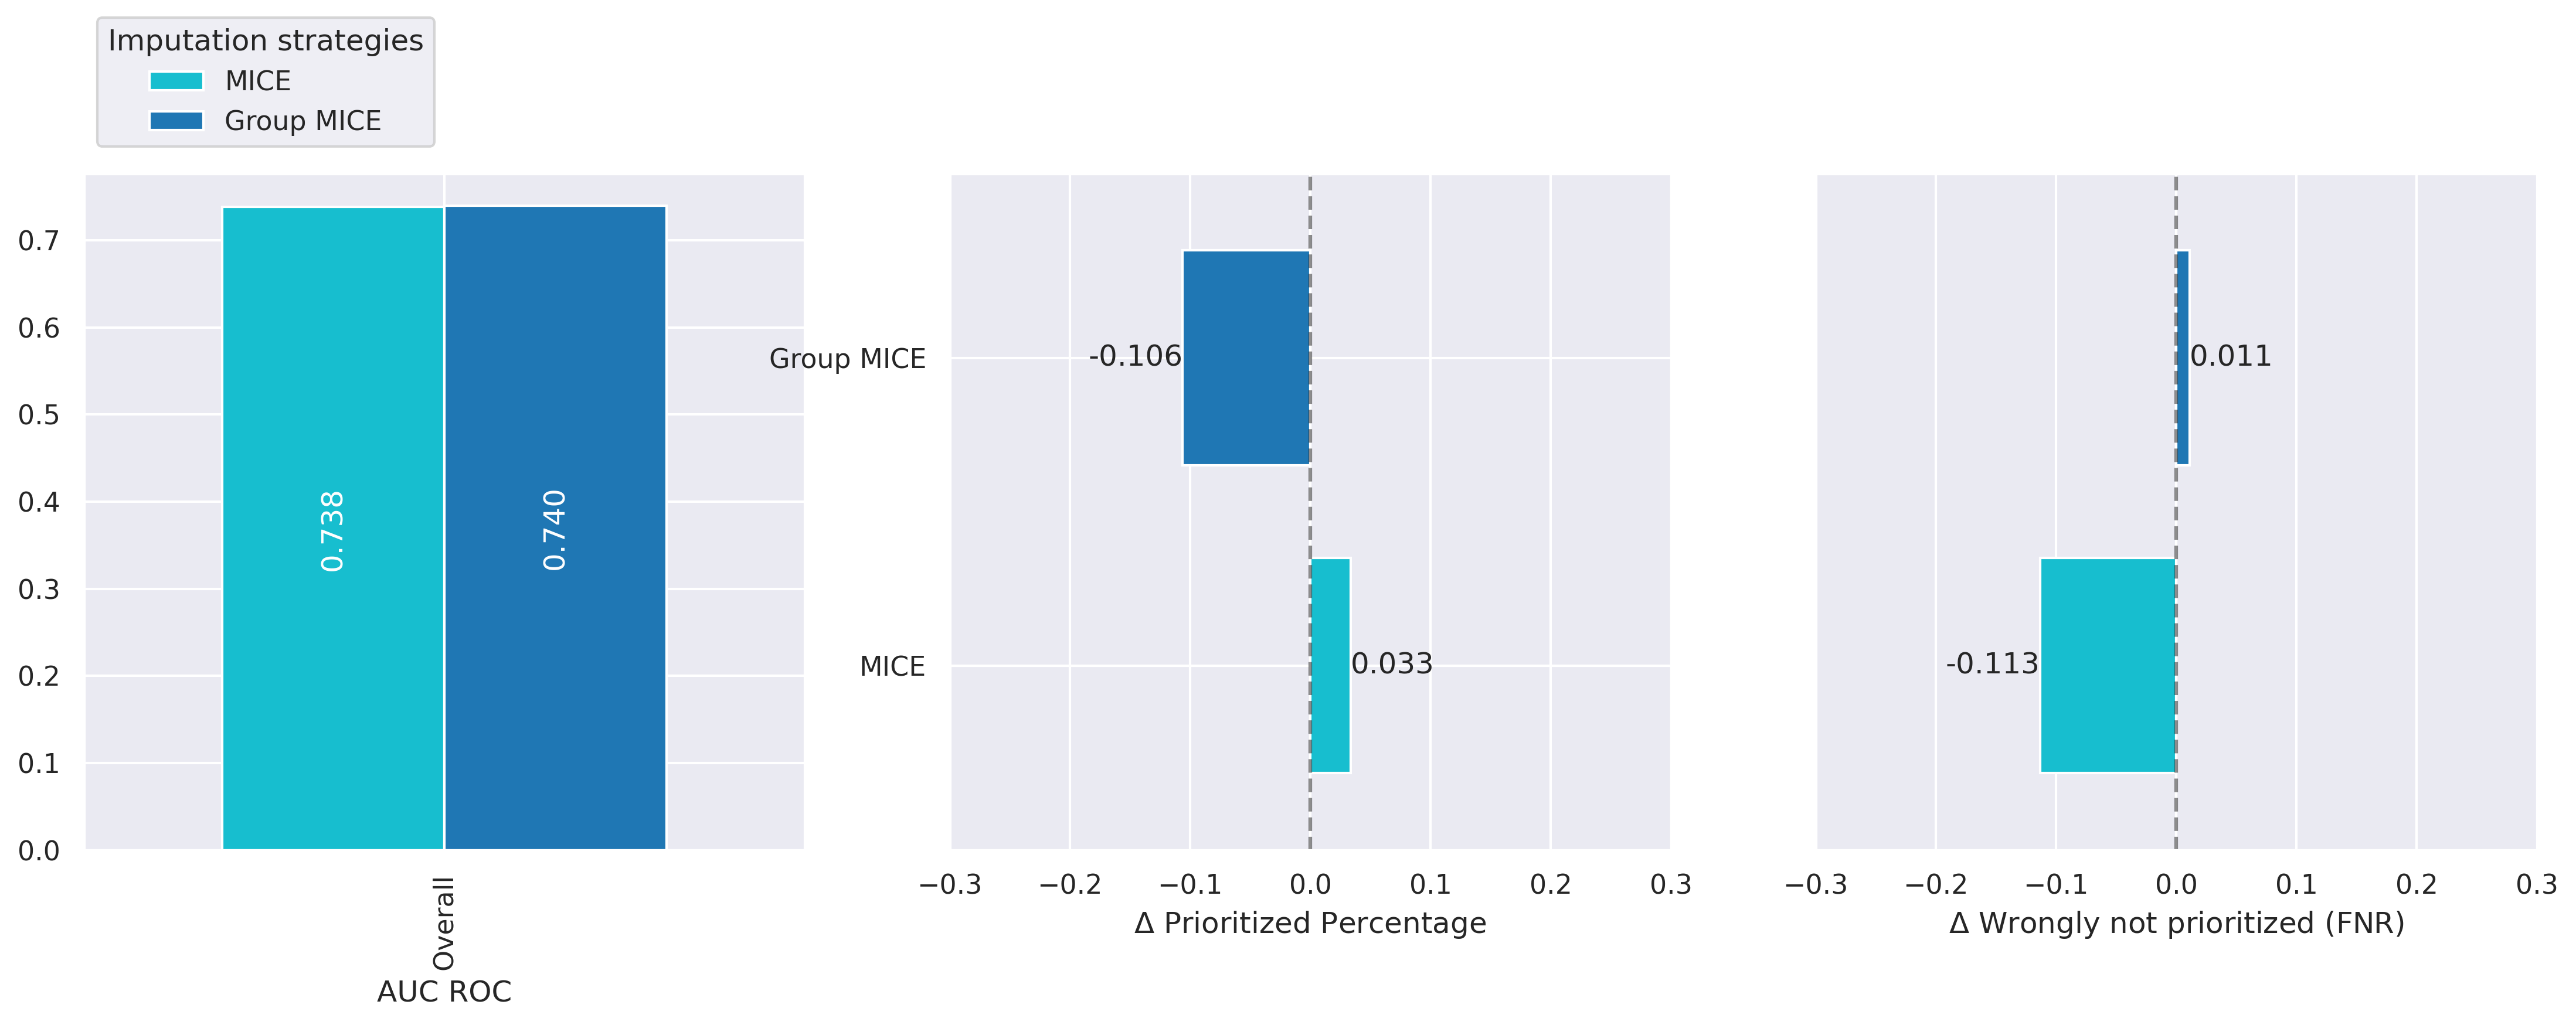

In [83]:
plt.figure(figsize=(18, 5))

# Display AUC metric
axes = plt.subplot(1,3,1)
this_avg_metric = average_metrics_df[['Demographic', 'Population', 'Strategy', 'Value']][average_metrics_df['Metric'] == 'AUC ROC'].pivot(index = ['Demographic', 'Population'], columns = 'Strategy')
this_avg_metric.columns = this_avg_metric.columns.droplevel(0)
this_avg_metric = this_avg_metric[['MICE', 'Group MICE']]
labels = this_avg_metric.columns[::-1]
this_avg_metric.loc['OVERALL'].plot.bar(ax = axes, width = 0.8, color = ['tab:cyan', 'tab:blue'])
axes.legend(loc='upper left', bbox_to_anchor=(0.0, 1.25), title = 'Imputation strategies')
plt.ylabel('')
plt.xlabel('AUC ROC')
for c in axes.containers:
    plt.bar_label(c, fmt = '%.3f', rotation = 'vertical', label_type = 'center', color = 'white')

# Display results for gap metrics
metric_list = ['Prioritized Percentage', 'Wrongly not prioritized (FNR)']
for index, metric in enumerate(metric_list):
  axes = plt.subplot(1,3,index + 2)
  this_gap_metric = gap_metrics_df[['Demographic', 'Strategy', 'Value']][gap_metrics_df['Metric'] == metric].pivot(index = 'Demographic', columns = 'Strategy')
  this_gap_metric.columns = this_gap_metric.columns.droplevel(0)
  this_gap_metric = this_gap_metric[['Group MICE', 'MICE']]
  this_gap_metric.loc['ETHNICITY'].plot.barh(ax = axes, width = 0.7, color = ['tab:blue', 'tab:cyan'])
  plt.ylabel('')
  if index != 0:
    plt.yticks([])
  plt.xlim(-0.30, 0.30)
  plt.axvline(0, ls = '--', alpha = 0.5, c = 'k')
  plt.xlabel('$\Delta$ {}'.format(metric))
  for c in axes.containers:
    plt.bar_label(c, fmt = '%.3f')
  plt.gca().invert_yaxis()

#### Claim 3: There is no one “best” imputation strategy for all populations and all missingness scenarios.
For example, while the Median and MICE strategies resulted in higher FNRs for women, those two strategies also lowered the FNR for publicly insured patients.

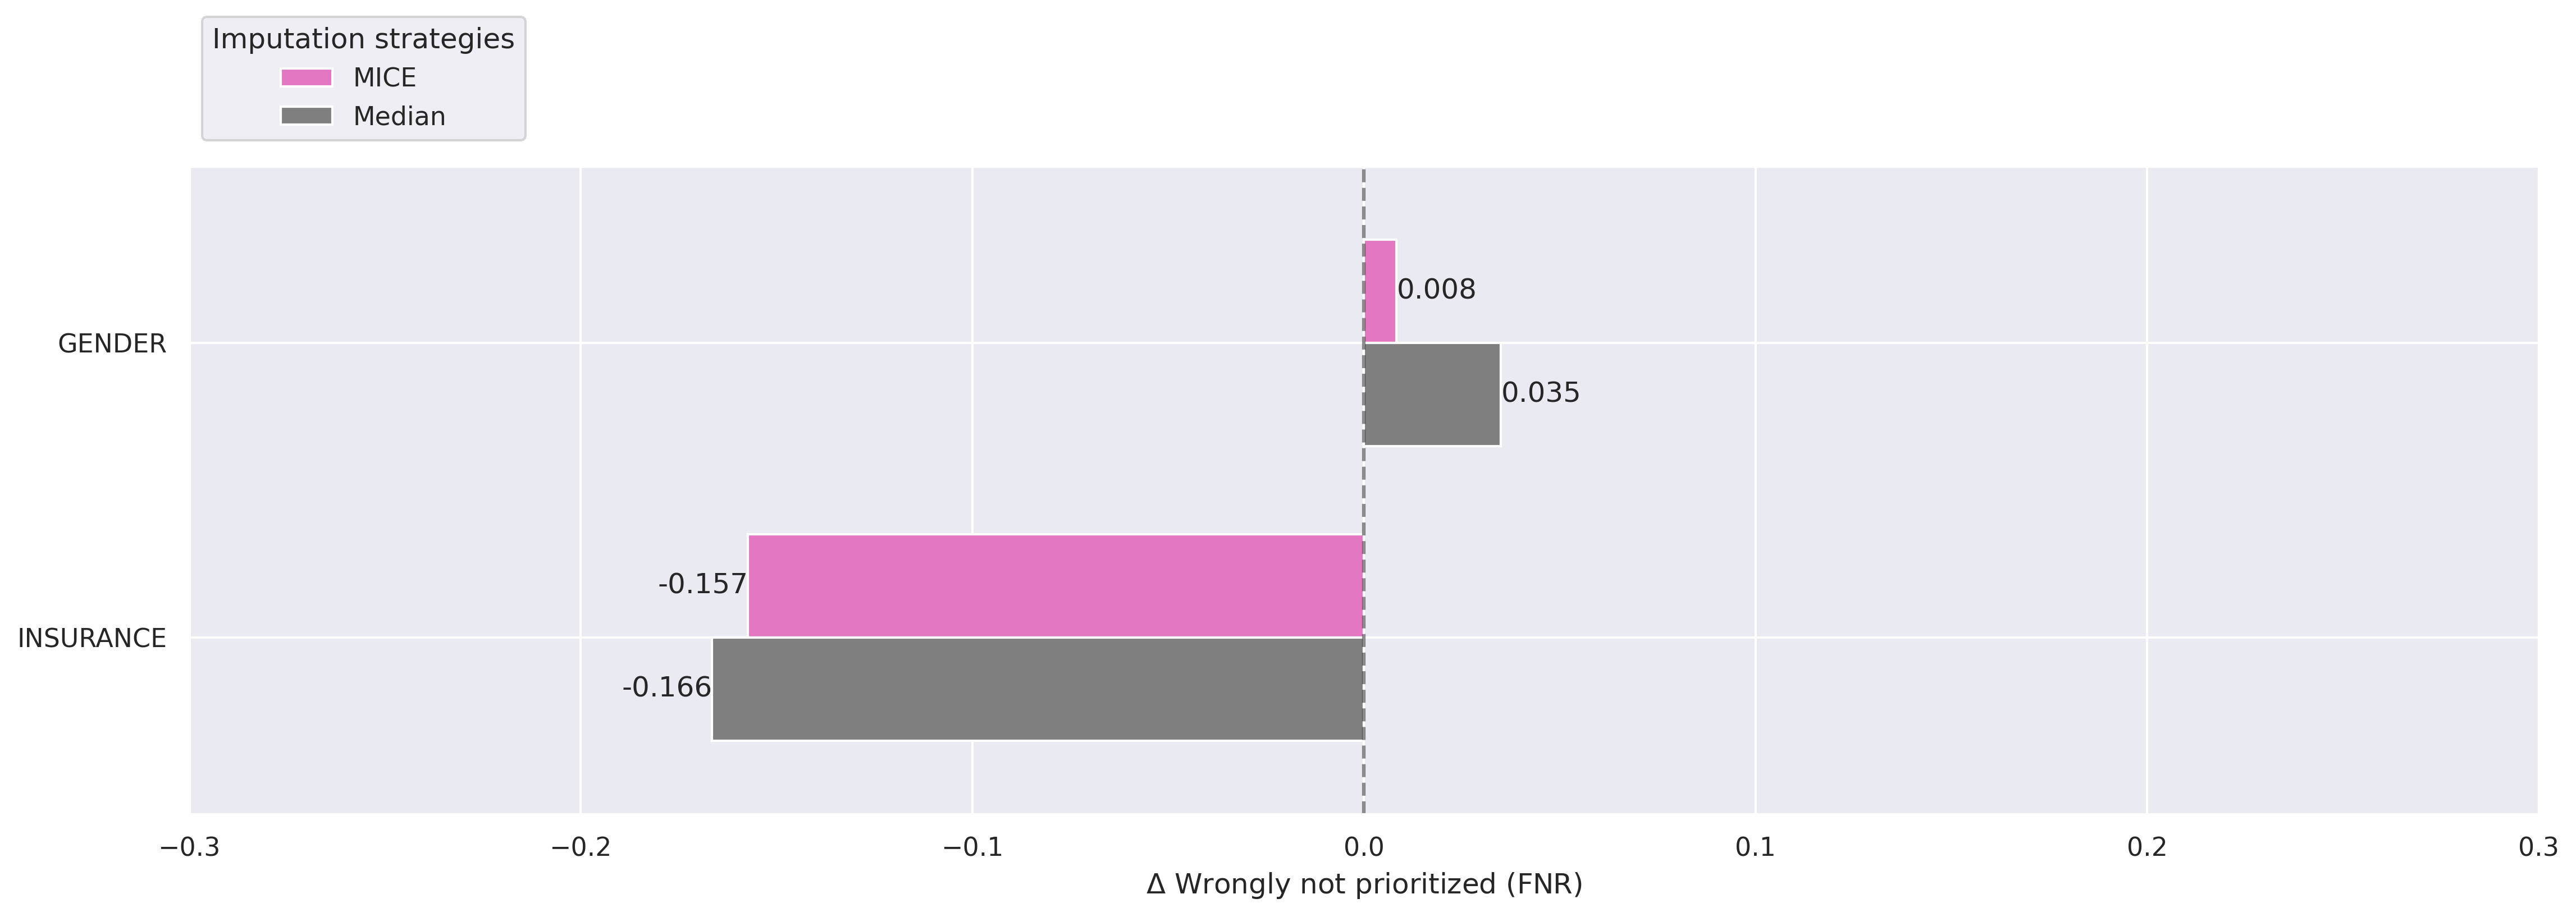

In [84]:
plt.figure(figsize=(18, 5))

# Display FNR gap
axes = plt.subplot(1,1,1)
this_gap_metric = gap_metrics_df[['Demographic', 'Strategy', 'Value']][gap_metrics_df['Metric'] == 'Wrongly not prioritized (FNR)'].pivot(index = 'Demographic', columns = 'Strategy')
this_gap_metric.columns = this_gap_metric.columns.droplevel(0)
this_gap_metric = this_gap_metric[['MICE', 'Median']]
this_gap_metric.loc[['GENDER', 'INSURANCE']].plot.barh(ax = axes, width = 0.7, color = ['tab:pink', 'tab:gray'])
axes.legend(loc='upper left', bbox_to_anchor=(0.0, 1.25), title = 'Imputation strategies')
plt.ylabel('')
plt.xlim(-0.30, 0.30)
plt.axvline(0, ls = '--', alpha = 0.5, c = 'k')
plt.xlabel('$\Delta$ {}'.format('Wrongly not prioritized (FNR)'))
for c in axes.containers:
    plt.bar_label(c, fmt = '%.3f')
plt.gca().invert_yaxis()

#### Claim 4: Adding covariates or missingness indicators does not always improve performance.
For example, while MICE improves performance for Black patients, Group MICE worsens it.

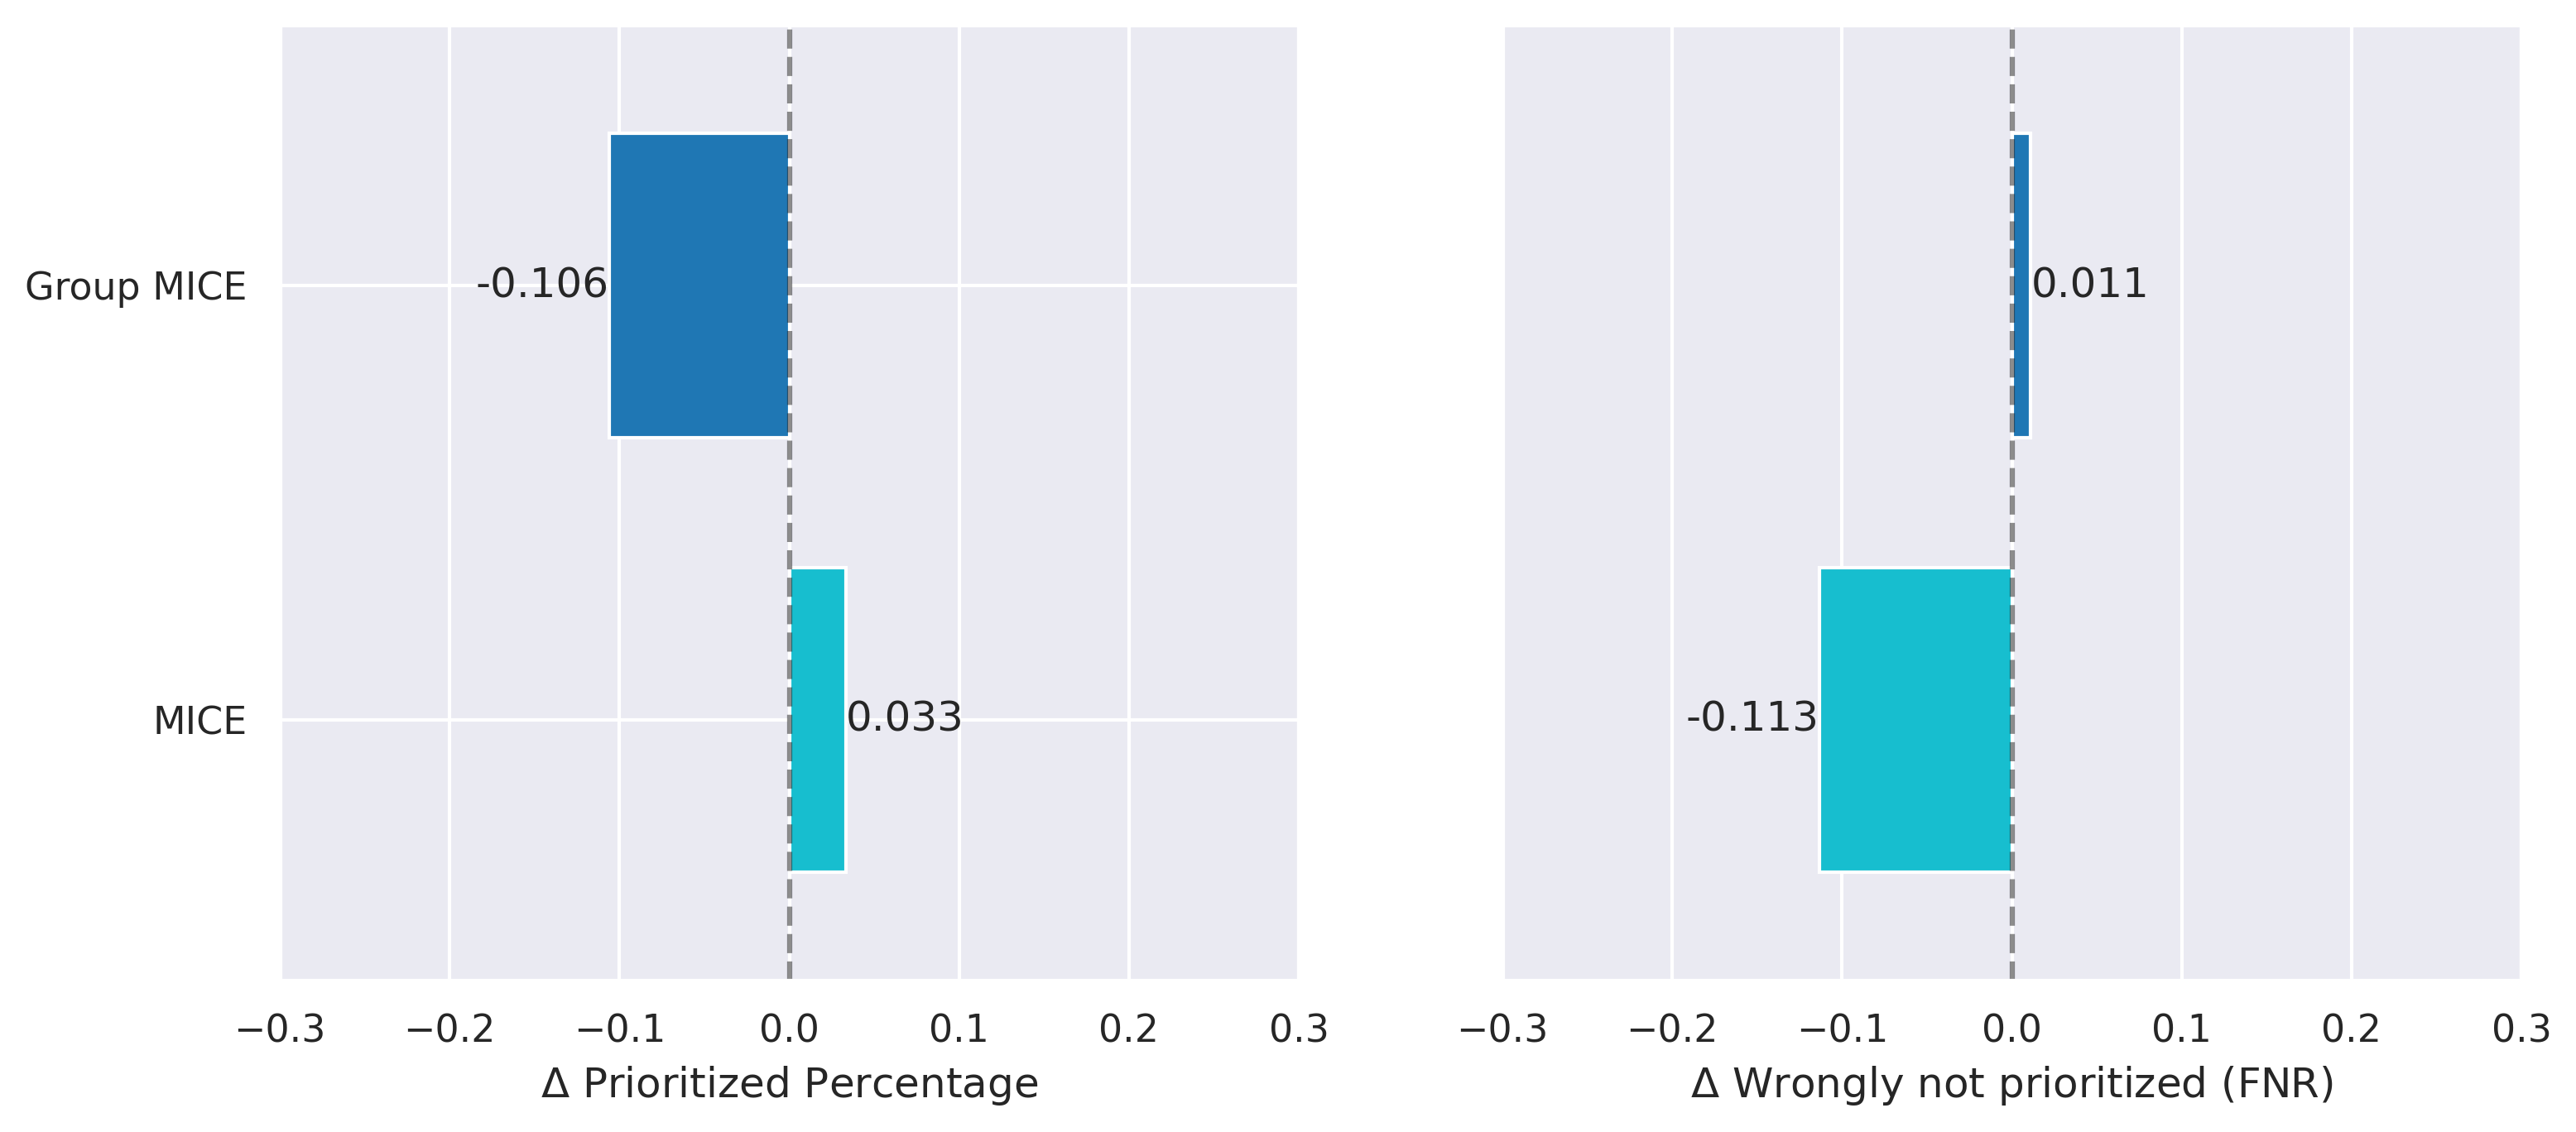

In [85]:
plt.figure(figsize=(18, 5))

# Display results for gap metrics
metric_list = ['Prioritized Percentage', 'Wrongly not prioritized (FNR)']
for index, metric in enumerate(metric_list):
  axes = plt.subplot(1,3,index + 2)
  this_gap_metric = gap_metrics_df[['Demographic', 'Strategy', 'Value']][gap_metrics_df['Metric'] == metric].pivot(index = 'Demographic', columns = 'Strategy')
  this_gap_metric.columns = this_gap_metric.columns.droplevel(0)
  this_gap_metric = this_gap_metric[['Group MICE', 'MICE']]
  this_gap_metric.loc['ETHNICITY'].plot.barh(ax = axes, width = 0.7, color = ['tab:blue', 'tab:cyan'])
  plt.ylabel('')
  if index != 0:
    plt.yticks([])
  plt.xlim(-0.30, 0.30)
  plt.axvline(0, ls = '--', alpha = 0.5, c = 'k')
  plt.xlabel('$\Delta$ {}'.format(metric))
  for c in axes.containers:
    plt.bar_label(c, fmt = '%.3f')
  plt.gca().invert_yaxis()

### Additional Experiments
In addition to reproducing the paper’s results, I did an ablation study where I removed the regularization component. I also tried replacing the logistic regression model with an MLP Classifier.

Both of these experiments did not have much impact on the results. The changes in AUC score, prioritized percentage, and FNR were minimal. The same imputation strategies that benefited or hurt a minority population still benefited or hurt the same minority population with only a few exceptions.

This implies that the effects of applying the imputation strategies are robust and will likely carry over to more complex models. Thus, these experimental results further support the four hypotheses discussed.

To see the results of these experiments, change the parameters below, run the code in Experiment.py, and then run the Analysis.py file.

To conduct the ablation study where regularization is removed, change:

`regularization = True` to `regularization = False`

To conduct the experiment where the logistic regression is replaced with an MLP Classifier, change:

`model_name = 'logistic_regression'` to `model_name = 'mlp_classifier'`


### References
[1] Jeanselme, V., De-Arteaga, M., Zhang, Z., Barrett, J., & Tom, B. (2022, November). Imputation Strategies Under Clinical Presence: Impact on Algorithmic Fairness. In _Machine Learning for Health_ (pp. 12-34). PMLR.

[2] Johnson, A. E., Pollard, T. J., Shen, L., Lehman, L. W. H., Feng, M., Ghassemi, M., ... & Mark, R. G. (2016). MIMIC-III, a freely accessible critical care database. _Scientific data_, 3(1), 1-9.

[3] Wang, S., McDermott, M. B., Chauhan, G., Ghassemi, M., Hughes, M. C., & Naumann, T. (2020, April). Mimic-extract: A data extraction, preprocessing, and representation pipeline for mimic-iii. In _Proceedings of the ACM conference on health, inference, and learning_ (pp. 222-235).